<a href="https://colab.research.google.com/github/AbhishekMohanty05/AbhishekMohanty01/blob/main/Newspaper_headline_sarcasm_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

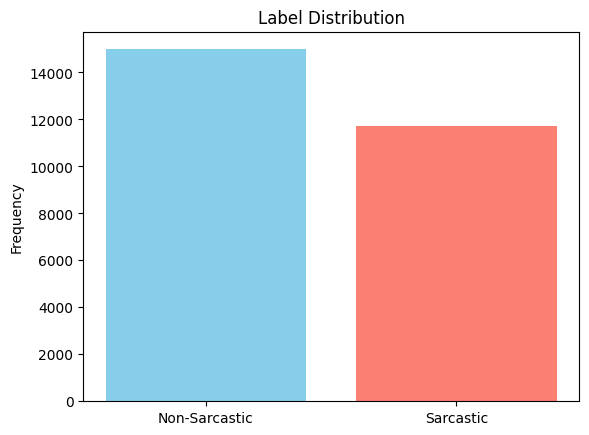

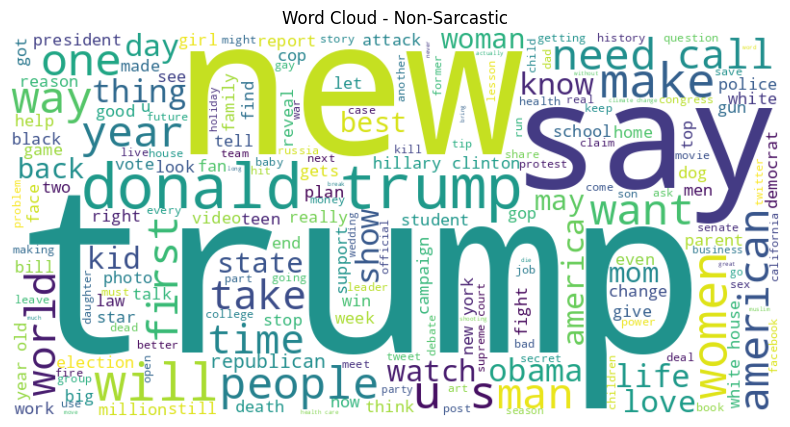

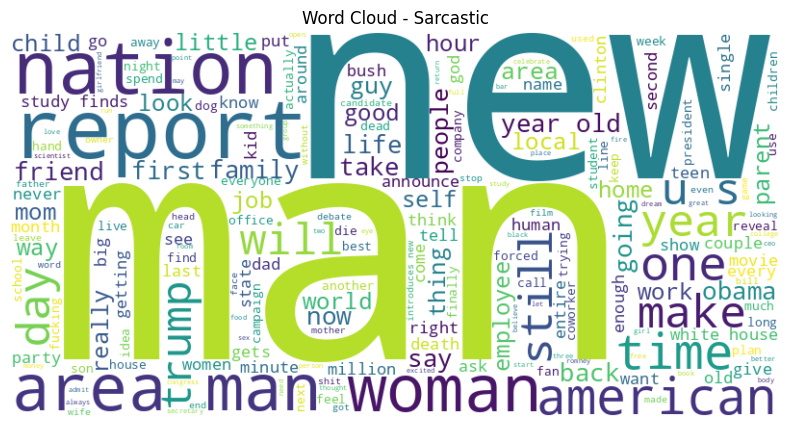

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/8
1069/1069 [==============================] - 120s 92ms/step - loss: 0.3356 - accuracy: 0.8571 - val_loss: 0.2049 - val_accuracy: 0.9137 - lr: 3.0000e-05
Epoch 2/8
1069/1069 [==============================] - 92s 86ms/step - loss: 0.1640 - accuracy: 0.9393 - val_loss: 0.3402 - val_accuracy: 0.8783 - lr: 3.0000e-05
Epoch 3/8
1069/1069 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9712
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
1069/1069 [==============================] - 91s 85ms/step - loss: 0.0847 - accuracy: 0.9712 - val_loss: 0.2407 - val_accuracy: 0.9204 - lr: 3.0000e-05
Epoch 4/8
1069/1069 [==============================] - 92s 86ms/step - loss: 0.0340 - accuracy: 0.9909 - val_loss: 0.3062 - val_accuracy: 0.9233 - lr: 1.5000e-05
Epoch 5/8
1069/1069 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9951
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.499999810534064e-06.
1069/1069 [===

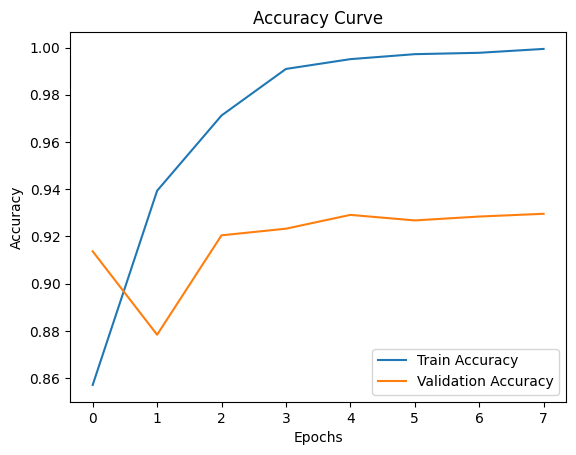

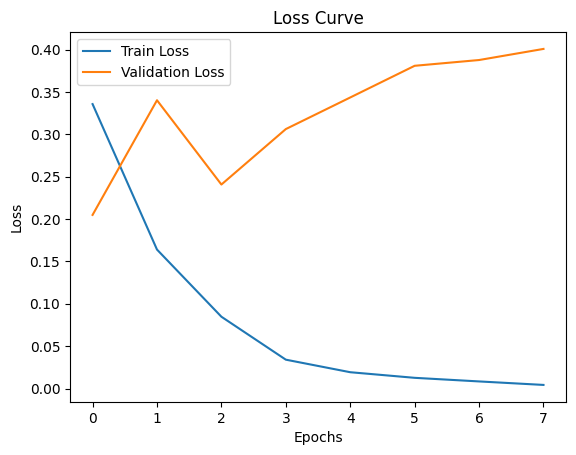

167/167 [==============================] - 7s 41ms/step - loss: 0.4458 - accuracy: 0.9276
Test Accuracy: 0.9276
167/167 [==============================] - 8s 40ms/step


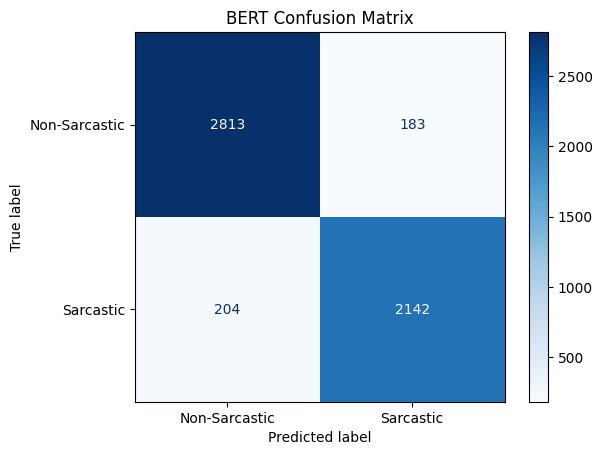

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      2996
           1       0.92      0.91      0.92      2346

    accuracy                           0.93      5342
   macro avg       0.93      0.93      0.93      5342
weighted avg       0.93      0.93      0.93      5342



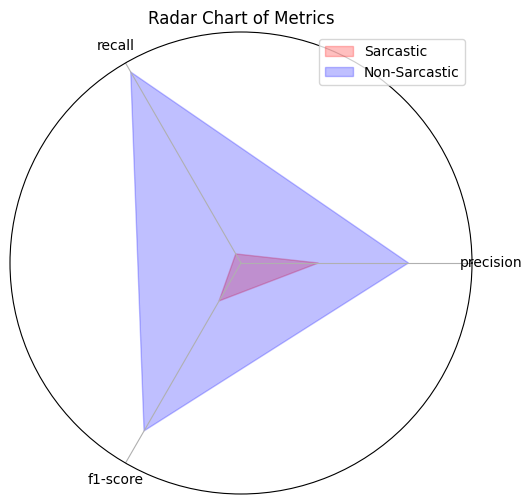

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv('/content/Sarcasm_Headlines_Dataset.csv')
df.columns = ['index', 'text_content', 'label']
df = df.dropna()

# Visualize label distribution
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'salmon'])
plt.xticks(ticks=label_counts.index, labels=['Non-Sarcastic', 'Sarcastic'])
plt.title("Label Distribution")
plt.ylabel("Frequency")
plt.show()

# Generate Word Clouds
def generate_wordcloud(df, label, title):
    text = " ".join(df[df['label'] == label]['text_content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

generate_wordcloud(df, label=0, title="Word Cloud - Non-Sarcastic")
generate_wordcloud(df, label=1, title="Word Cloud - Sarcastic")

# Train-test split
X = df['text_content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization
def tokenize_data(texts, tokenizer, max_len=64):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

train_tokens = tokenize_data(X_train, tokenizer)
test_tokens = tokenize_data(X_test, tokenizer)

tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define BERT-based model with improvements
def build_bert_model(bert_model):
    input_ids = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(64,), dtype=tf.int32, name="attention_mask")

    # Unfreeze some layers for better fine-tuning
    for layer in bert_model.layers[-6:]:
        layer.trainable = True

    bert_output = bert_model(input_ids, attention_mask=attention_mask).last_hidden_state
    cls_token = bert_output[:, 0, :]

    dense = tf.keras.layers.Dense(128, activation='relu')(cls_token)
    bn = tf.keras.layers.BatchNormalization()(dense)
    dropout = tf.keras.layers.Dropout(0.3)(bn)
    output = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')(dropout)

    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

bert_classifier = build_bert_model(distilbert_model)

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-6, verbose=1)

# Train the model
history = bert_classifier.fit(
    [train_tokens['input_ids'], train_tokens['attention_mask']],
    y_train,
    validation_split=0.2,
    epochs=8,
    batch_size=16,
    callbacks=[lr_scheduler]
)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate and visualize results
loss, accuracy = bert_classifier.evaluate(
    [test_tokens['input_ids'], test_tokens['attention_mask']], y_test
)
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = (bert_classifier.predict([test_tokens['input_ids'], test_tokens['attention_mask']]) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Sarcastic', 'Sarcastic'])
disp.plot(cmap=plt.cm.Blues)
plt.title("BERT Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Radar Chart for metrics
metrics = classification_report(y_test, y_pred, output_dict=True)
categories = ['precision', 'recall', 'f1-score']
sarcastic_scores = [metrics['1'][metric] for metric in categories]
non_sarcastic_scores = [metrics['0'][metric] for metric in categories]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
sarcastic_scores += sarcastic_scores[:1]
non_sarcastic_scores += non_sarcastic_scores[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, sarcastic_scores, color='red', alpha=0.25, label='Sarcastic')
ax.fill(angles, non_sarcastic_scores, color='blue', alpha=0.25, label='Non-Sarcastic')
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='upper right')
plt.title("Radar Chart of Metrics")
plt.show()

# Save the model
bert_classifier.save('/content/optimized_bert_model')


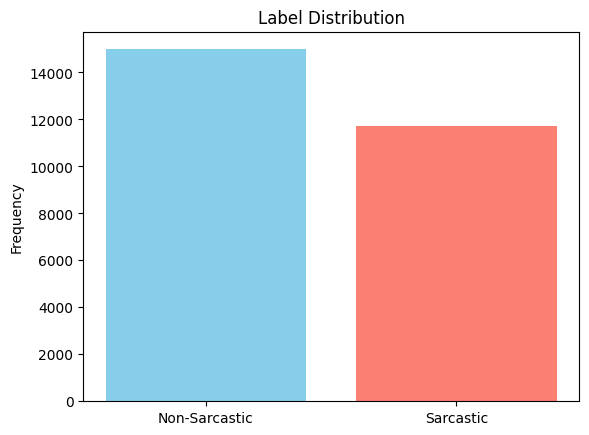

In [ ]:
# Required Libraries
import pandas as pd
import numpy as np
import networkx as nx
!pip install node2vec
from node2vec import Node2Vec
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

# Enable Mixed Precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Load Dataset
df = pd.read_csv('/content/Sarcasm_Headlines_Dataset.csv')
df.columns = ['index', 'text_content', 'label']
df = df.dropna()

# Visualize Label Distribution
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'salmon'])
plt.xticks(ticks=label_counts.index, labels=['Non-Sarcastic', 'Sarcastic'])
plt.title("Label Distribution")
plt.ylabel("Frequency")
plt.show()

# Train-Test Split
X = df['text_content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization (using a smaller model)
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
max_len = 64  # Reduced max token length

def tokenize_texts(texts):
    return tokenizer(
        list(texts),
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

train_tokens = tokenize_texts(X_train)
test_tokens = tokenize_texts(X_test)






In [ ]:

# Graph Representation Using Node2Vec (reduced dimensions)
def build_graph(texts):
    G = nx.Graph()
    for text in texts:
        words = text.split()
        for i, word in enumerate(words[:-1]):
            G.add_edge(word, words[i + 1])
    return G

graph = build_graph(X_train)
node2vec = Node2Vec(graph, dimensions=64, walk_length=8, num_walks=20, workers=2)  # Reduced dimensions
graph_model = node2vec.fit(window=5, min_count=1)
def generate_graph_embeddings(texts):
    embeddings = []
    for text in texts:
        words = text.split()
        valid_embeddings = [graph_model.wv[word] for word in words if word in graph_model.wv]
        if valid_embeddings:
            text_embedding = np.mean(valid_embeddings, axis=0)
        else:
            text_embedding = np.zeros(graph_model.wv.vector_size)  # Default to zero vector
        embeddings.append(text_embedding)
    return np.array(embeddings)


train_graph_embeddings = generate_graph_embeddings(X_train)
test_graph_embeddings = generate_graph_embeddings(X_test)

print(f"Train embeddings shape: {train_graph_embeddings.shape}")
print(f"Test embeddings shape: {test_graph_embeddings.shape}")


# Simulate image embeddings (replace this with real image embeddings if needed)
train_visual_embeddings = np.random.rand(len(X_train), 256)  # Random vectors for now
test_visual_embeddings = np.random.rand(len(X_test), 256)

print(f"Train visual embeddings shape: {train_visual_embeddings.shape}")
print(f"Test visual embeddings shape: {test_visual_embeddings.shape}")

Computing transition probabilities:   0%|          | 0/32227 [00:00<?, ?it/s]

Train embeddings shape: (21367, 64)
Test embeddings shape: (5342, 64)
Train visual embeddings shape: (21367, 256)
Test visual embeddings shape: (5342, 256)


In [ ]:
    def build_multimodal_model():
    # Text inputs
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Load the transformer model
    transformer = TFAutoModel.from_pretrained('distilroberta-base', return_dict=True)

    class TransformerBlock(tf.keras.layers.Layer):
        def __init__(self, model_name, **kwargs): # Indented this line
            super(TransformerBlock, self).__init__(**kwargs) # Indented this line
            self.transformer = TFAutoModel.from_pretrained(model_name, return_dict=True) # Indented this line

        def call(self, inputs): # Indented this line
            input_ids, attention_mask = inputs # Indented this line
            outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask) # Indented this line
            return outputs.last_hidden_state[:, 0, :]  # CLS token # Indented this line

def build_multimodal_model(): # This is a duplicate function definition, removed
    # Text inputs
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # Transformer block
    cls_token = TransformerBlock('distilroberta-base')([input_ids, attention_mask])

    # Graph input
    graph_input = tf.keras.layers.Input(shape=(64,), name="graph_input")
    # Visual input
    visual_input = tf.keras.layers.Input(shape=(256,), name="visual_input")

    # Combine all inputs
    combined = tf.keras.layers.Concatenate()([cls_token, graph_input, visual_input])
    dense = tf.keras.layers.Dense(128, activation='relu')(combined)  # Reduced units
    dropout = tf.keras.layers.Dropout(0.3)(dense)
    output = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')(dropout)

    # Define and compile the model
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_mask, graph_input, visual_input],
        outputs=output
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

multimodal_model = build_multimodal_model()

# Train Model (reduced epochs and batch size)
history = multimodal_model.fit(
    [train_tokens['input_ids'], train_tokens['attention_mask'], train_graph_embeddings, train_visual_embeddings],
    y_train,
    validation_split=0.2,
    epochs=5,  # Reduced epochs
    batch_size=8  # Reduced batch size
)

# Evaluate Model
loss, accuracy = multimodal_model.evaluate(
    [test_tokens['input_ids'], test_tokens['attention_mask'], test_graph_embeddings, test_visual_embeddings],
    y_test
)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
y_pred = (multimodal_model.predict(
    [test_tokens['input_ids'], test_tokens['attention_mask'], test_graph_embeddings, test_visual_embeddings]
) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Sarcastic', 'Sarcastic'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



IndentationError: expected an indented block after function definition on line 1 (<ipython-input-11-b5db4d58a626>, line 3)